In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad

from bin import utils
from tqdm import tqdm

In [188]:
gdata = sc.read_h5ad('../20240702-Exclusive/RNA/spatial.combined.bin20.h5')
gdata = gdata[:, gdata.var_names.str.startswith('sg')].copy()

In [189]:
sgs = gdata.var_names.str.split('ing_', n=1).str[0]
sgs_grouped = pd.DataFrame(gdata.X.toarray(), columns=gdata.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()

cgdata = ad.AnnData(sgs_grouped, obs=gdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
cgdata.obsm['spatial'] = gdata.obsm['spatial']
gdata = cgdata.copy()

/tmp/ipykernel_50996/1702212738.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [4]:
from scipy.spatial import distance_matrix

In [193]:
gdata_a = gdata[gdata.obs['marker'] == 'A'].copy()
gdata_a = gdata_a[gdata_a.obsm['spatial'][:, 1] > 4000].copy()
proportion_bin = {}
for threshold in tqdm(np.linspace(1, 501, 20)):
    proportion_bin[threshold] = []
    for guide in gdata.var_names:
        if guide == 'sgNon-target': continue
        guide_data = gdata_a[gdata_a[:, guide].X > 0].copy()
        ntc_data = gdata_a[gdata_a[:, 'sgNon-target'].X > 0].copy()
        in_distance = ((distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
        proportion_bin[threshold].append(in_distance / guide_data.shape[0])

100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


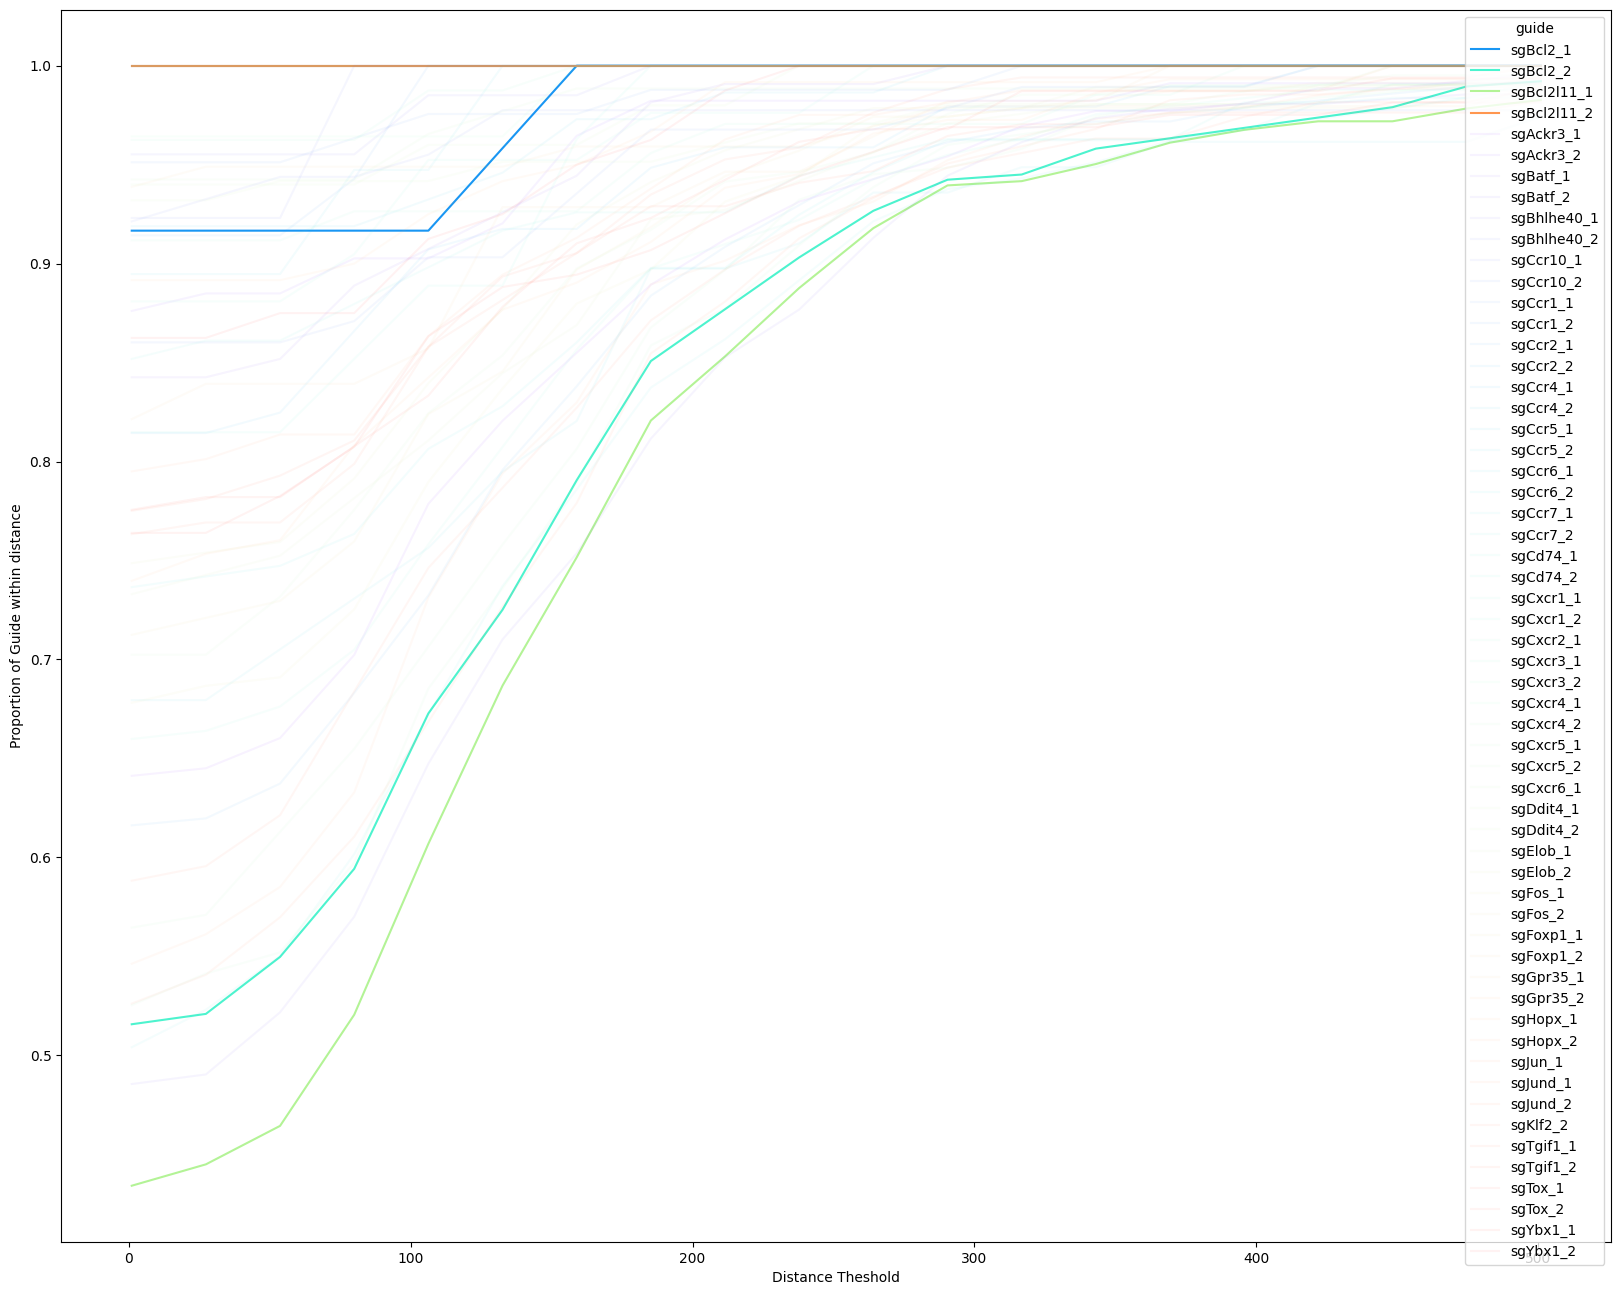

In [197]:
d_df = pd.DataFrame(proportion_bin).melt()
d_df.index = gdata_[:, gdata_.var_names != 'sgNon-target'].var_names.tolist() * 20
d_df.reset_index(inplace=True)
plt.figure(figsize=(20, 16))
sns.lineplot(d_df[d_df['index'].str.startswith('sgBcl2')], x='variable', y='value', hue='index', palette='rainbow', alpha=1)
sns.lineplot(d_df[~d_df['index'].str.startswith('sgBcl2')], x='variable', y='value', hue='index', palette='rainbow', alpha=0.05)
plt.xlabel('Distance Theshold')
plt.ylabel('Proportion of Guide within distance')
plt.legend(title='guide')

In [212]:
gdata_b = gdata[gdata.obs['marker'] == 'B'].copy()
gdata_b = gdata_b[gdata_b.obsm['spatial'][:, 1] < 6500].copy()
proportion_cin = {}
for threshold in tqdm(np.linspace(1, 501, 20)):
    proportion_cin[threshold] = []
    for guide in gdata.var_names:
        if guide == 'sgNon-target': continue
        guide_data = gdata_b[gdata_b[:, guide].X > 0].copy()
        ntc_data = gdata_b[gdata_b[:, 'sgNon-target'].X > 0].copy()
        in_distance = ((distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
        proportion_cin[threshold].append(in_distance / guide_data.shape[0])

100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


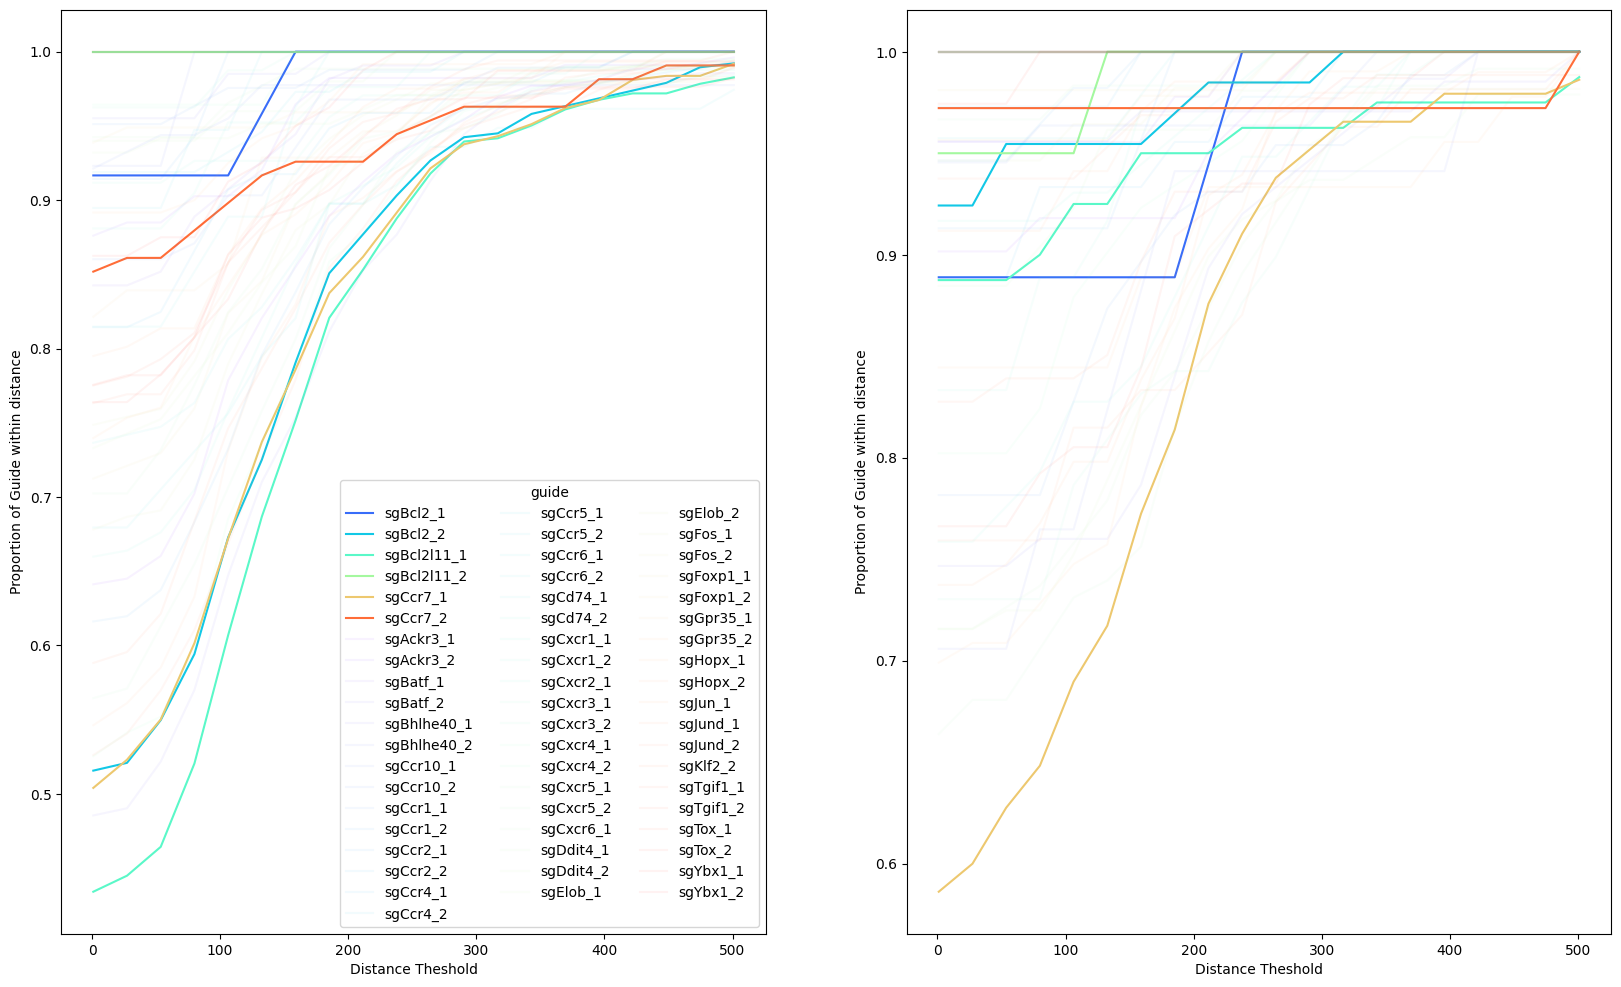

In [213]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

filter_ = d_df['index'].str.startswith('sgBcl2') | d_df['index'].str.startswith('sgCcr7')

d_df = pd.DataFrame(proportion_bin).melt()
d_df.index = gdata_[:, gdata_.var_names != 'sgNon-target'].var_names.tolist() * 20
d_df.reset_index(inplace=True)
sns.lineplot(d_df[filter_], x='variable', y='value', hue='index', legend=True, palette='rainbow', alpha=1, ax=ax[0])
sns.lineplot(d_df[~filter_], x='variable', y='value', hue='index', legend=True, palette='rainbow', alpha=0.05, ax=ax[0])
ax[0].set_xlabel('Distance Theshold')
ax[0].set_ylabel('Proportion of Guide within distance')

d_df = pd.DataFrame(proportion_cin).melt()
d_df.index = gdata_b[:, gdata_b.var_names != 'sgNon-target'].var_names.tolist() * 20
d_df.reset_index(inplace=True)
sns.lineplot(d_df[filter_], x='variable', y='value', hue='index', legend=False, palette='rainbow', alpha=1, ax=ax[1])
sns.lineplot(d_df[~filter_], x='variable', y='value', hue='index', legend=False, palette='rainbow', alpha=0.05, ax=ax[1])
ax[1].set_xlabel('Distance Theshold')
ax[1].set_ylabel('Proportion of Guide within distance')
ax[0].legend(title='guide', ncol=3)

In [ ]:
proportion = {}
for guide in tqdm(gdata_.var_names):
    if guide == 'sgNon-target': continue
    guide_data = gdata_[gdata_[:, guide].X > 1].copy()
    ntc_data = gdata_[gdata_[:, 'sgNon-target'].X > 1].copy()
    threshold = 1
    in_distance = guide_data[(distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0, guide].X.sum()
    #in_distance = np.apply_along_axis(lambda x: guide_data[x][:, guide].X.sum(), 0, (distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold)).sum()
    proportion[guide] = in_distance / guide_data[:, guide].X.sum()

 93%|█████████▎| 55/59 [00:01<00:00, 52.32it/s]/tmp/ipykernel_50996/3741076182.py:9: RuntimeWarning: invalid value encountered in divide
  proportion[guide] = in_distance / guide_data[:, guide].X.sum()
100%|██████████| 59/59 [00:01<00:00, 48.89it/s]


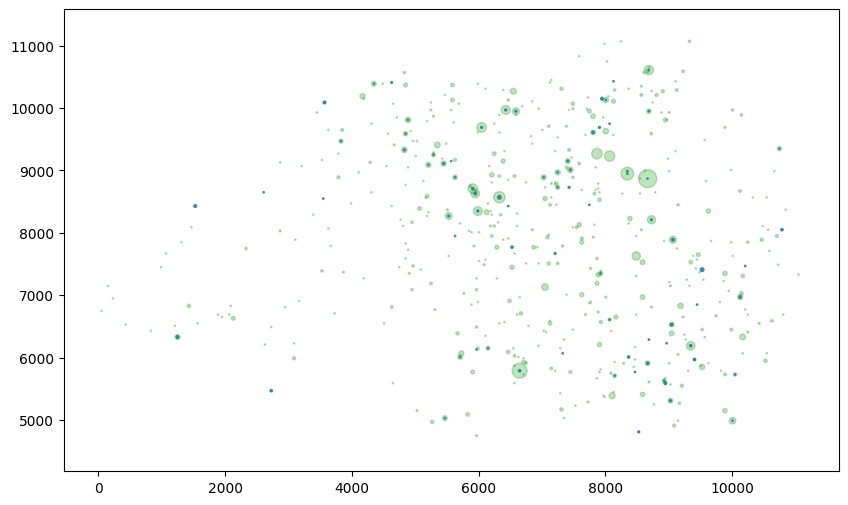

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# sns.scatterplot(spatial_df, x='coord_x', y='coord_y', hue='guide', size=0.001, legend=True, ax=ax[1])
colors = sns.color_palette("tab10", len(gdata_.var_names.unique()))
color_mapping = {guide: color for guide, color in zip(gdata_.var_names.unique(), colors)}
for guide in gdata_.var_names:
    if guide not in ['sgNon-target', 'sgCcr6_1']: continue
    if guide == 'sgNon-target': alpha = 0.3
    else: alpha = 0.8
    utils.plot_dot(gdata_, gene_name=guide, ax=ax, square=False, alpha=alpha, color=color_mapping[guide])

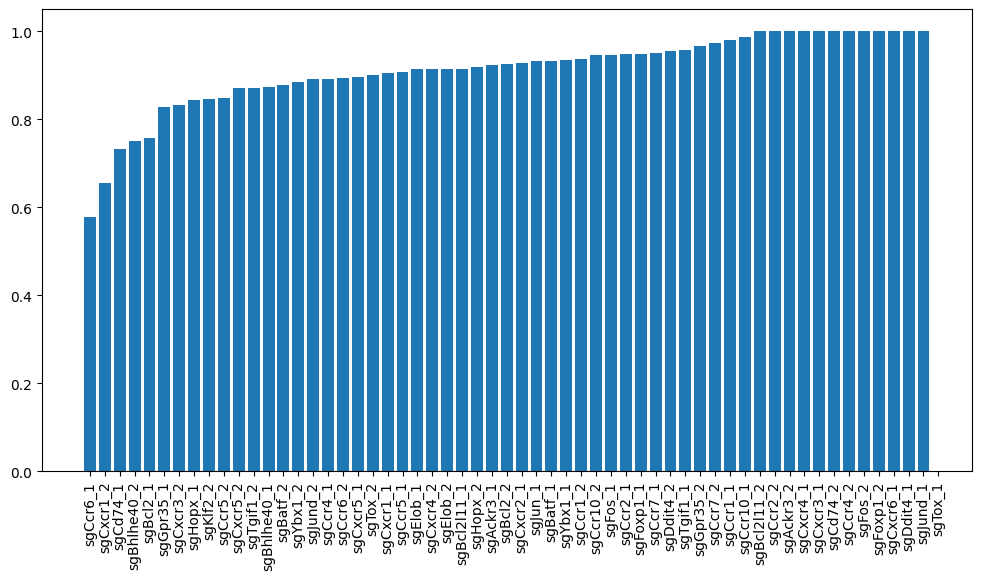

In [ ]:
d_df = pd.DataFrame(proportion, index=['proportion']).T.sort_values(by='proportion')
plt.figure(figsize=(12, 6))
plt.bar(d_df.index, d_df.proportion)
plt.xticks(rotation=90)
plt.show()

In [ ]:
proportion = {}
for threshold in tqdm(np.linspace(1, 501, 20)):
    proportion[threshold] = []
    for guide in gdata.var_names:
        guide_data = gdata_[gdata_[:, guide].X > 0].copy()
        ntc_data = gdata_[gdata_[:, 'sgNon-target'].X > 0].copy()
        in_distance = guide_data[(distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0, guide].X.sum()
        proportion[threshold].append(in_distance / guide_data[:, guide].X.sum())

100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


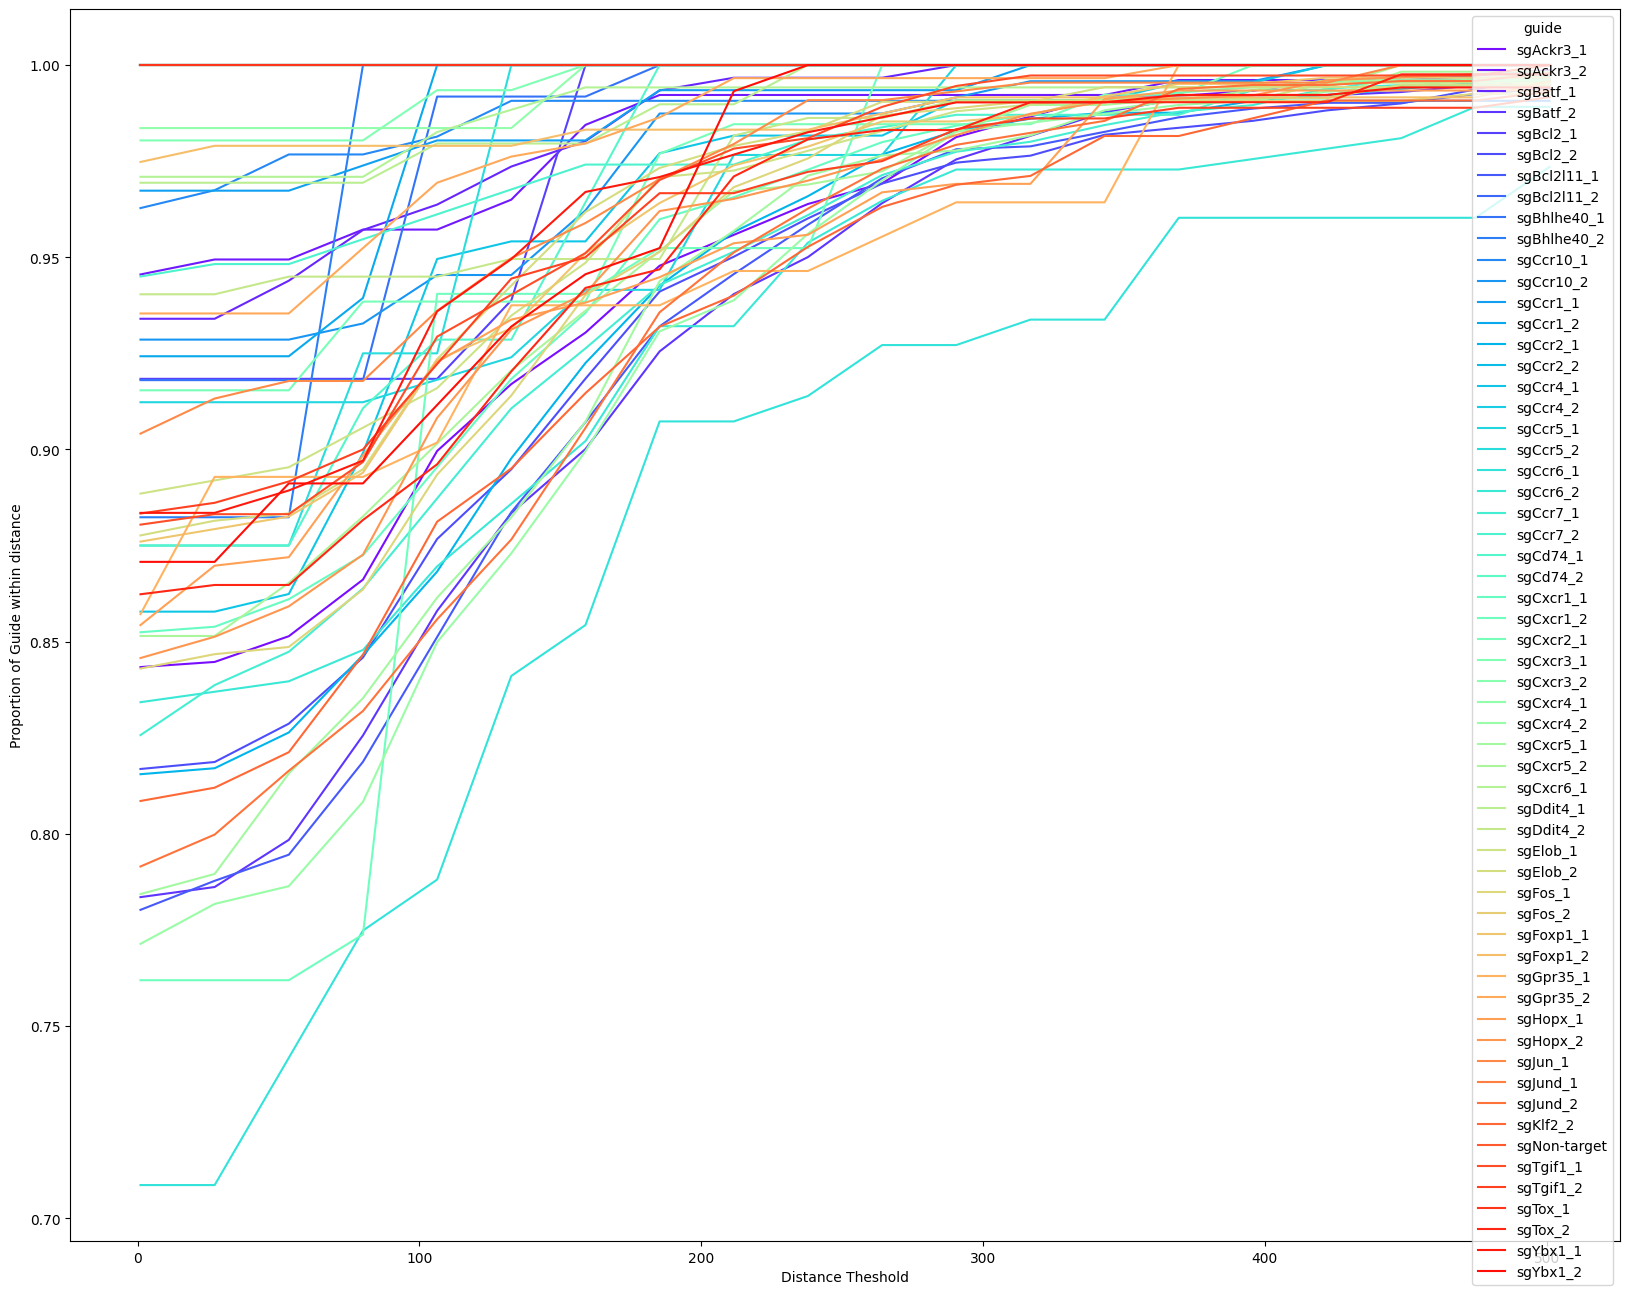

In [ ]:
d_df = pd.DataFrame(proportion).melt()
d_df.index = guide_data.var_names.tolist() * 20
d_df.reset_index(inplace=True)
plt.figure(figsize=(20, 16))
sns.lineplot(d_df, x='variable', y='value', hue='index', palette='rainbow')
plt.xlabel('Distance Theshold')
plt.ylabel('Proportion of Guide within distance')
plt.legend(title='guide')

# T

In [54]:
gdata[(gdata.X.toarray().sum(axis=1) > 0)]

View of AnnData object with n_obs × n_vars = 258024 × 67
    obs: 'marker'
    obsm: 'spatial'

In [50]:
gdata[((gdata.X.toarray() > 0).sum(axis=1) > 1)]

View of AnnData object with n_obs × n_vars = 120033 × 67
    obs: 'marker'
    obsm: 'spatial'

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


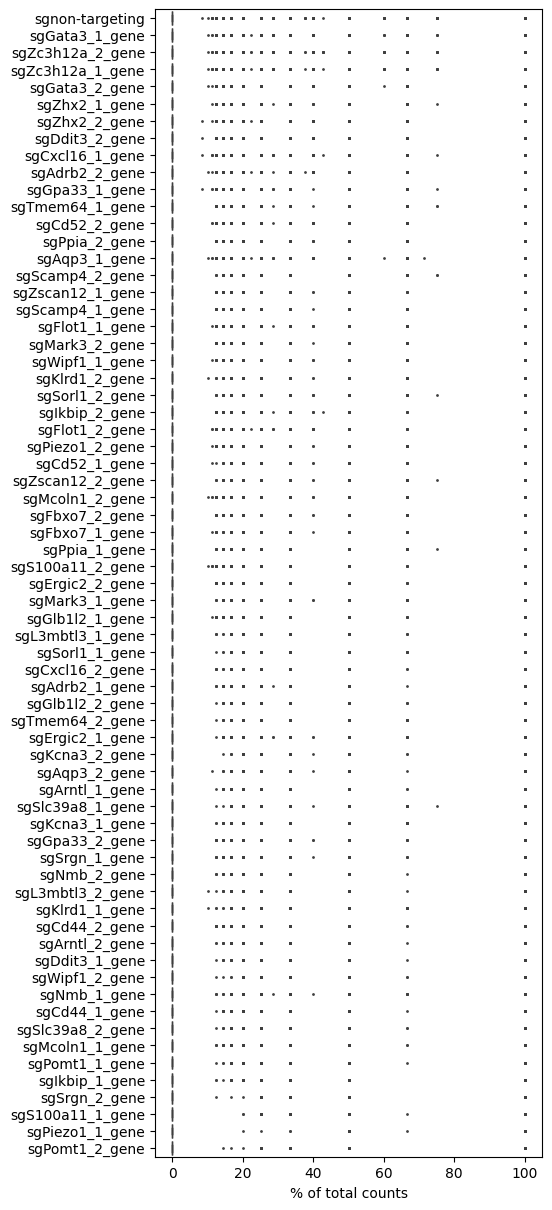

In [36]:
sc.pl.highest_expr_genes(gdata, n_top=67)

In [10]:
pdf

index  Bins of NTC
3  B922-1          196
2  B922-2         2949
1  B926-1         4223
5  B924-1         5405
4  B924-2        17294
0  B926-2        18830

In [4]:
pdf

index  Bins of NTC
3  B922-1          196
2  B922-2         2949
1  B926-1         4223
5  B924-1         5405
4  B924-2        17294
0  B926-2        18830

/tmp/ipykernel_17104/2552151331.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pdf, x='index', y='Bins of NTC', palette='Reds', alpha=0.5)


([], [])

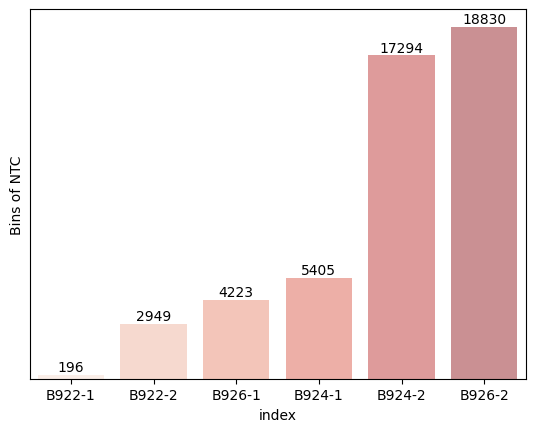

In [15]:
ntc_dict = {}
for marker in gdata.obs.marker.unique():
    ntc_dict[marker] = gdata[gdata.obs['marker'] == marker, 'sgnon-targeting'].X.sum()
pdf = pd.DataFrame(ntc_dict, index=['Bins of NTC']).T.reset_index().sort_values(by='Bins of NTC')
sns.barplot(pdf, x='index', y='Bins of NTC', palette='Reds', alpha=0.5)
for cnt in range(6):
    plt.text(cnt, pdf.reset_index().loc[cnt, 'Bins of NTC'] + 200, pdf.reset_index().loc[cnt, 'Bins of NTC'], ha='center')
plt.yticks([])

In [2]:
gdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.bin20.h5')

In [17]:
from scipy.spatial import distance_matrix
proportion = {}
for marker in gdata.obs.marker.unique():
    gdata_ = gdata[gdata.obs['marker'] == marker].copy()
    proportion[marker] = {}
    for threshold in tqdm(np.linspace(1, 501, 20)):
        proportion[marker][threshold] = []
        for guide in gdata.var_names:
            if guide == 'sgnon-targeting': continue
            guide_data = gdata_[gdata_[:, guide].X > 0].copy()
            ntc_data = gdata_[gdata_[:, 'sgnon-targeting'].X > 0].copy()
            in_distance = guide_data[(distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0, guide].X.sum()
            proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_17104/3239570697.py:13: RuntimeWarning: invalid value encountered in scalar divide
  proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())
  5%|▌         | 1/20 [01:57<37:13, 117.54s/it]/tmp/ipykernel_17104/3239570697.py:13: RuntimeWarning: invalid value encountered in scalar divide
  proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())
 10%|█         | 2/20 [04:18<39:22, 131.28s/it]/tmp/ipykernel_17104/3239570697.py:13: RuntimeWarning: invalid value encountered in scalar divide
  proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())
 15%|█▌        | 3/20 [06:39<38:26, 135.65s/it]/tmp/ipykernel_17104/3239570697.py:13: RuntimeWarning: invalid value encountered in scalar divide
  proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())
 20%|██        | 4/20 [08:59<36:38, 137.43s/it]/tmp/ipykernel_17104/3239570697.py:13: RuntimeWarn

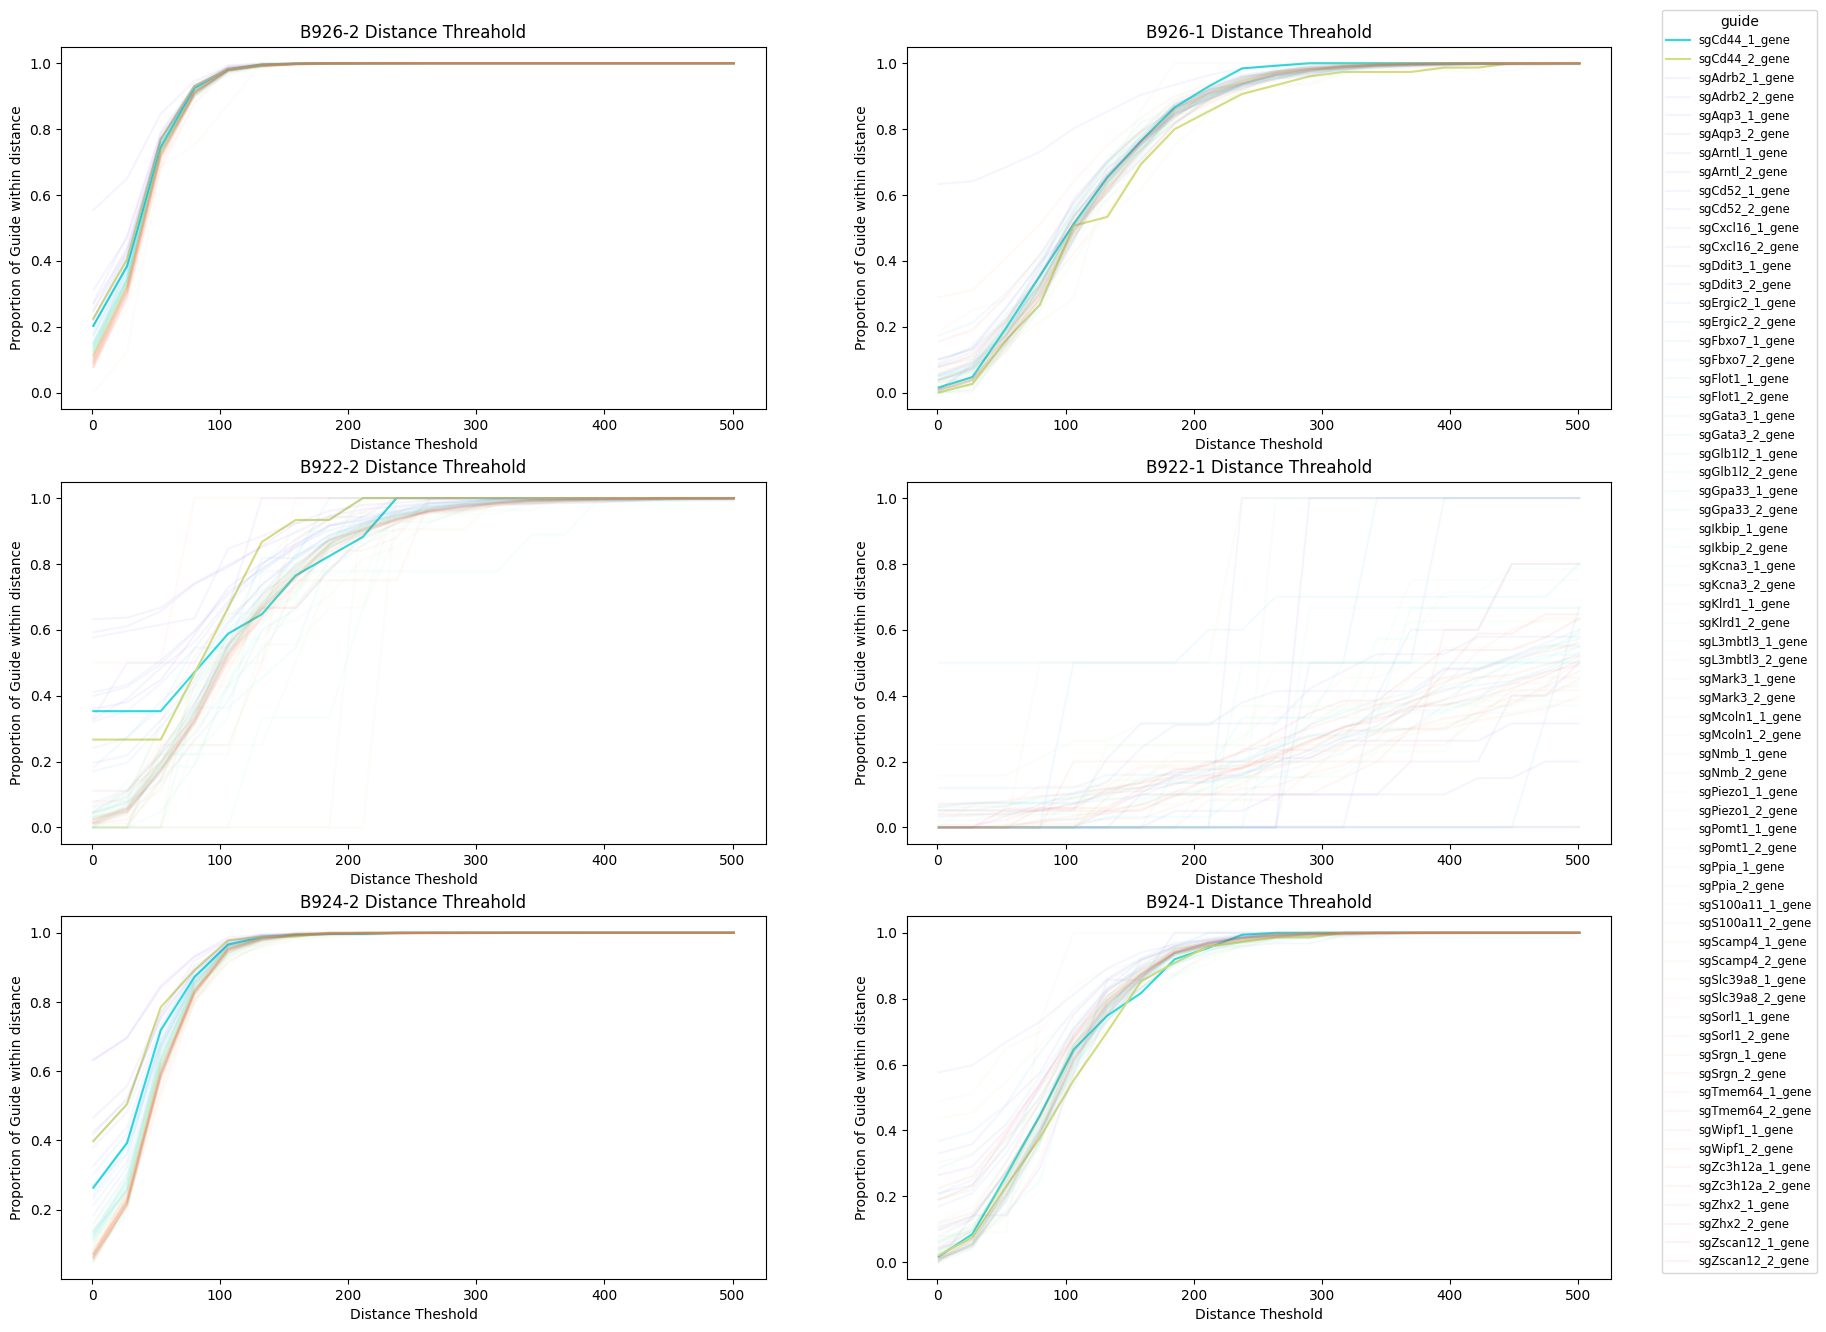

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(20, 16))
for idx, marker in enumerate(gdata.obs.marker.unique()):
    d_df = pd.DataFrame(proportion[marker]).melt()
    d_df.index = gdata[:, gdata.var_names != 'sgnon-targeting'].var_names.tolist() * 20
    d_df.reset_index(inplace=True)
    
    if idx == 5: legend = True
    else: legend = False
    sns.lineplot(d_df[d_df['index'].str.startswith('sgCd44')], x='variable', y='value', hue='index', palette='rainbow', ax=ax[idx // 2, idx % 2], legend = legend, alpha=1)
    sns.lineplot(d_df[~d_df['index'].str.startswith('sgCd44')], x='variable', y='value', hue='index', palette='rainbow', ax=ax[idx // 2, idx % 2], legend = legend, alpha=0.05)
    ax[idx // 2, idx % 2].set_xlabel('Distance Theshold')
    ax[idx // 2, idx % 2].set_ylabel('Proportion of Guide within distance')
    ax[idx // 2, idx % 2].set_title(marker + ' Distance Threahold')
    if idx == 5: ax[idx // 2, idx % 2].legend(title='guide', loc='lower right', fontsize='small', bbox_to_anchor=(1.3, 0))

In [59]:
proportion_bin = {}
for marker in gdata.obs.marker.unique():
    gdata_ = gdata[gdata.obs['marker'] == marker].copy()
    proportion_bin[marker] = {}
    for threshold in tqdm(np.linspace(1, 501, 20)):
        proportion_bin[marker][threshold] = []
        for guide in gdata.var_names:
            if guide == 'sgnon-targeting': continue
            guide_data = gdata_[gdata_[:, guide].X > 0].copy()
            ntc_data = gdata_[gdata_[:, 'sgnon-targeting'].X > 0].copy()
            in_distance = ((distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
            proportion_bin[marker][threshold].append(in_distance / guide_data.shape[0])

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_68877/3533827254.py:12: RuntimeWarning: invalid value encountered in scalar divide
  proportion_bin[marker][threshold].append(in_distance / guide_data.shape[0])
  5%|▌         | 1/20 [01:34<30:03, 94.93s/it]/tmp/ipykernel_68877/3533827254.py:12: RuntimeWarning: invalid value encountered in scalar divide
  proportion_bin[marker][threshold].append(in_distance / guide_data.shape[0])
 10%|█         | 2/20 [03:07<28:08, 93.81s/it]/tmp/ipykernel_68877/3533827254.py:12: RuntimeWarning: invalid value encountered in scalar divide
  proportion_bin[marker][threshold].append(in_distance / guide_data.shape[0])
 15%|█▌        | 3/20 [04:40<26:28, 93.42s/it]/tmp/ipykernel_68877/3533827254.py:12: RuntimeWarning: invalid value encountered in scalar divide
  proportion_bin[marker][threshold].append(in_distance / guide_data.shape[0])
 20%|██        | 4/20 [06:13<24:51, 93.19s/it]/tmp/ipykernel_68877/3533827254.py:12: RuntimeWarning: invalid value encou

In [23]:
gdata_ = gdata[gdata.obs['marker'] == 'B924-2']
random_cnt = [int(x) for x in np.linspace(20, gdata_.shape[0] // 50, 5)]
proportion_rand = {}
for threshold in tqdm(np.linspace(1, 501, 20)):
    proportion_rand[threshold] = []
    for cnt in random_cnt:
        random_bins = np.random.choice(gdata_.obs_names, cnt, replace=False)
        ntc_data = gdata_[gdata_[:, 'sgnon-targeting'].X > 0].copy()
        in_distance = ((distance_matrix(gdata_[random_bins].obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
        proportion_rand[threshold].append(in_distance / cnt)

  0%|          | 0/20 [00:10<?, ?it/s]


KeyboardInterrupt: 

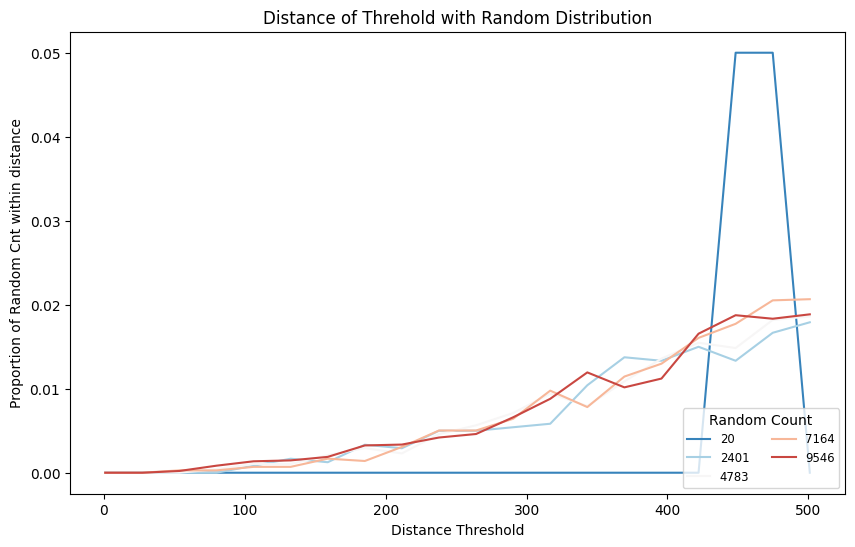

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

d_df = pd.DataFrame(proportion_rand).melt()
d_df.index = random_cnt * 20
d_df.reset_index(inplace=True)
d_df['index'] = d_df['index'].astype('str')

sns.lineplot(d_df, x='variable', y='value', hue='index', palette='RdBu_r', ax=ax, legend=True, alpha=1)
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Proportion of Random Cnt within distance')
ax.legend(title='Random Count', loc='lower right', fontsize='small', bbox_to_anchor=(1, 0), ncols=2)
plt.title('Distance of Threhold with Random Distribution')
plt.show()

In [32]:
proportion_rand = {}
for marker in gdata.obs.marker.unique():
    gdata_ = gdata[gdata.obs['marker'] == marker]
    random_cnt = 10000
    proportion_rand[marker] = []
    for threshold in tqdm(np.linspace(1, 501, 20)):
        cnt = random_cnt
        random_bins = np.random.choice(gdata_.obs_names, cnt, replace=False)
        ntc_data = gdata_[gdata_[:, 'sgnon-targeting'].X > 2].copy()
        in_distance = ((distance_matrix(gdata_[random_bins].obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
        proportion_rand[marker].append(in_distance / cnt)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:01<00:00, 19.31it/s]


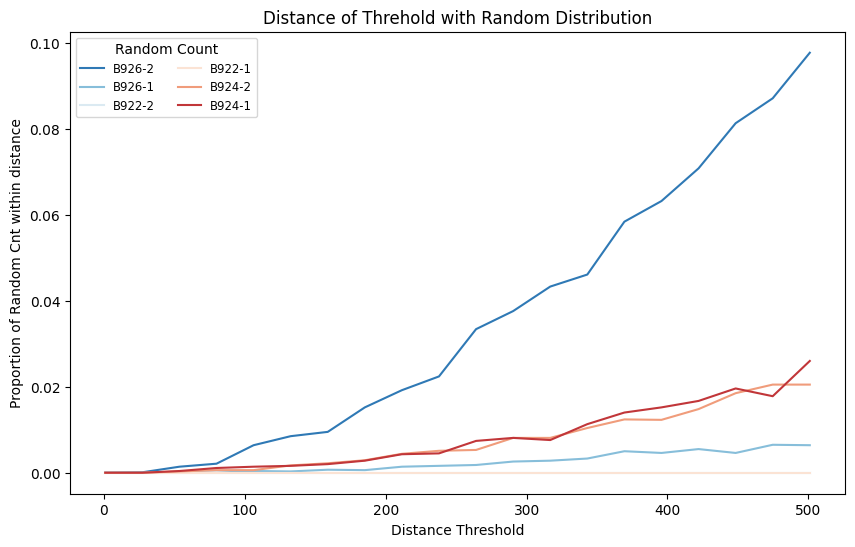

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

d_df = pd.DataFrame(proportion_rand).melt()
d_df['threshold'] = list(np.linspace(1, 501, 20)) * 6

sns.lineplot(d_df, x='threshold', y='value', hue='variable', palette='RdBu_r', ax=ax, legend=True, alpha=1)
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Proportion of Random Cnt within distance')
ax.legend(title='Random Count', loc='upper left', fontsize='small', ncols=2)
plt.title('Distance of Threhold with Random Distribution')
plt.show()

In [62]:
d_df = pd.DataFrame(proportion_rand, index=random_cnt)
d_df.apply(lambda x: np.multiply(ln_scoring, x), axis=1).sum(axis=1)

20      0.626724
2401    0.623716
4783    0.612667
7164    0.626938
9546    0.639138
dtype: float64

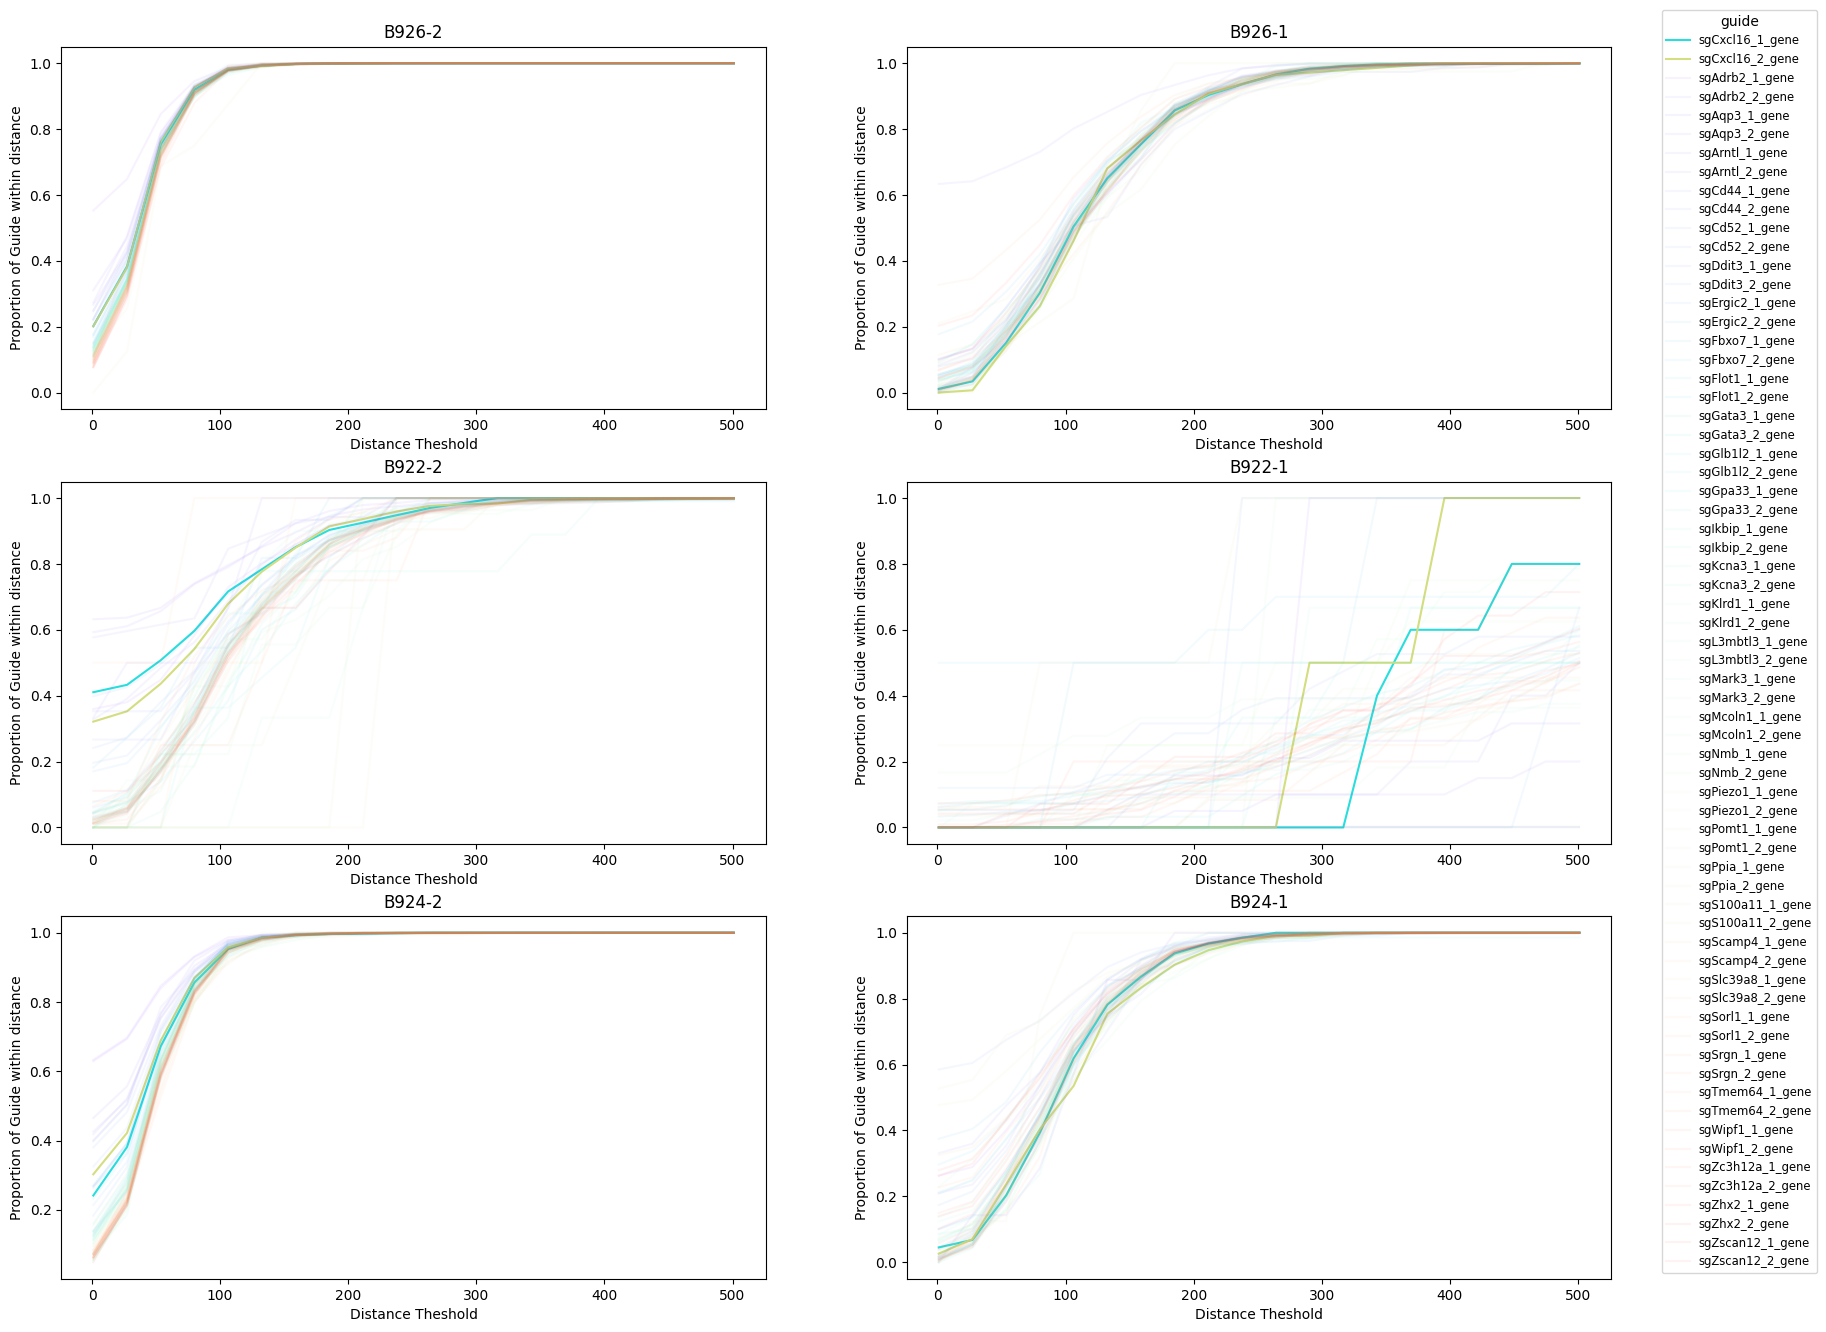

In [69]:
fig, ax = plt.subplots(3, 2, figsize=(20, 16))
for idx, marker in enumerate(gdata.obs.marker.unique()):
    d_df = pd.DataFrame(proportion_bin[marker]).melt()
    d_df.index = gdata[:, gdata.var_names != 'sgnon-targeting'].var_names.tolist() * 20
    d_df.reset_index(inplace=True)
    
    if idx == 5: legend = True
    else: legend = False
    sns.lineplot(d_df[d_df['index'].str.startswith('sgCxcl16')], x='variable', y='value', hue='index', palette='rainbow', ax=ax[idx // 2, idx % 2], legend = legend, alpha=1)
    sns.lineplot(d_df[~d_df['index'].str.startswith('sgCxcl16')], x='variable', y='value', hue='index', palette='rainbow', ax=ax[idx // 2, idx % 2], legend = legend, alpha=0.05)
    ax[idx // 2, idx % 2].set_xlabel('Distance Theshold')
    ax[idx // 2, idx % 2].set_ylabel('Proportion of Guide within distance')
    if idx == 5: ax[idx // 2, idx % 2].legend(title='guide', loc='lower right', fontsize='small', bbox_to_anchor=(1.3, 0))
    ax[idx // 2, idx % 2].set_title(marker)

/tmp/ipykernel_17104/2941220629.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ln_sc.index, rotation=90)
/tmp/ipykernel_17104/2941220629.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(linear_sc.index, rotation=90)
/tmp/ipykernel_17104/2941220629.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(exp_sc.index, rotation=90)


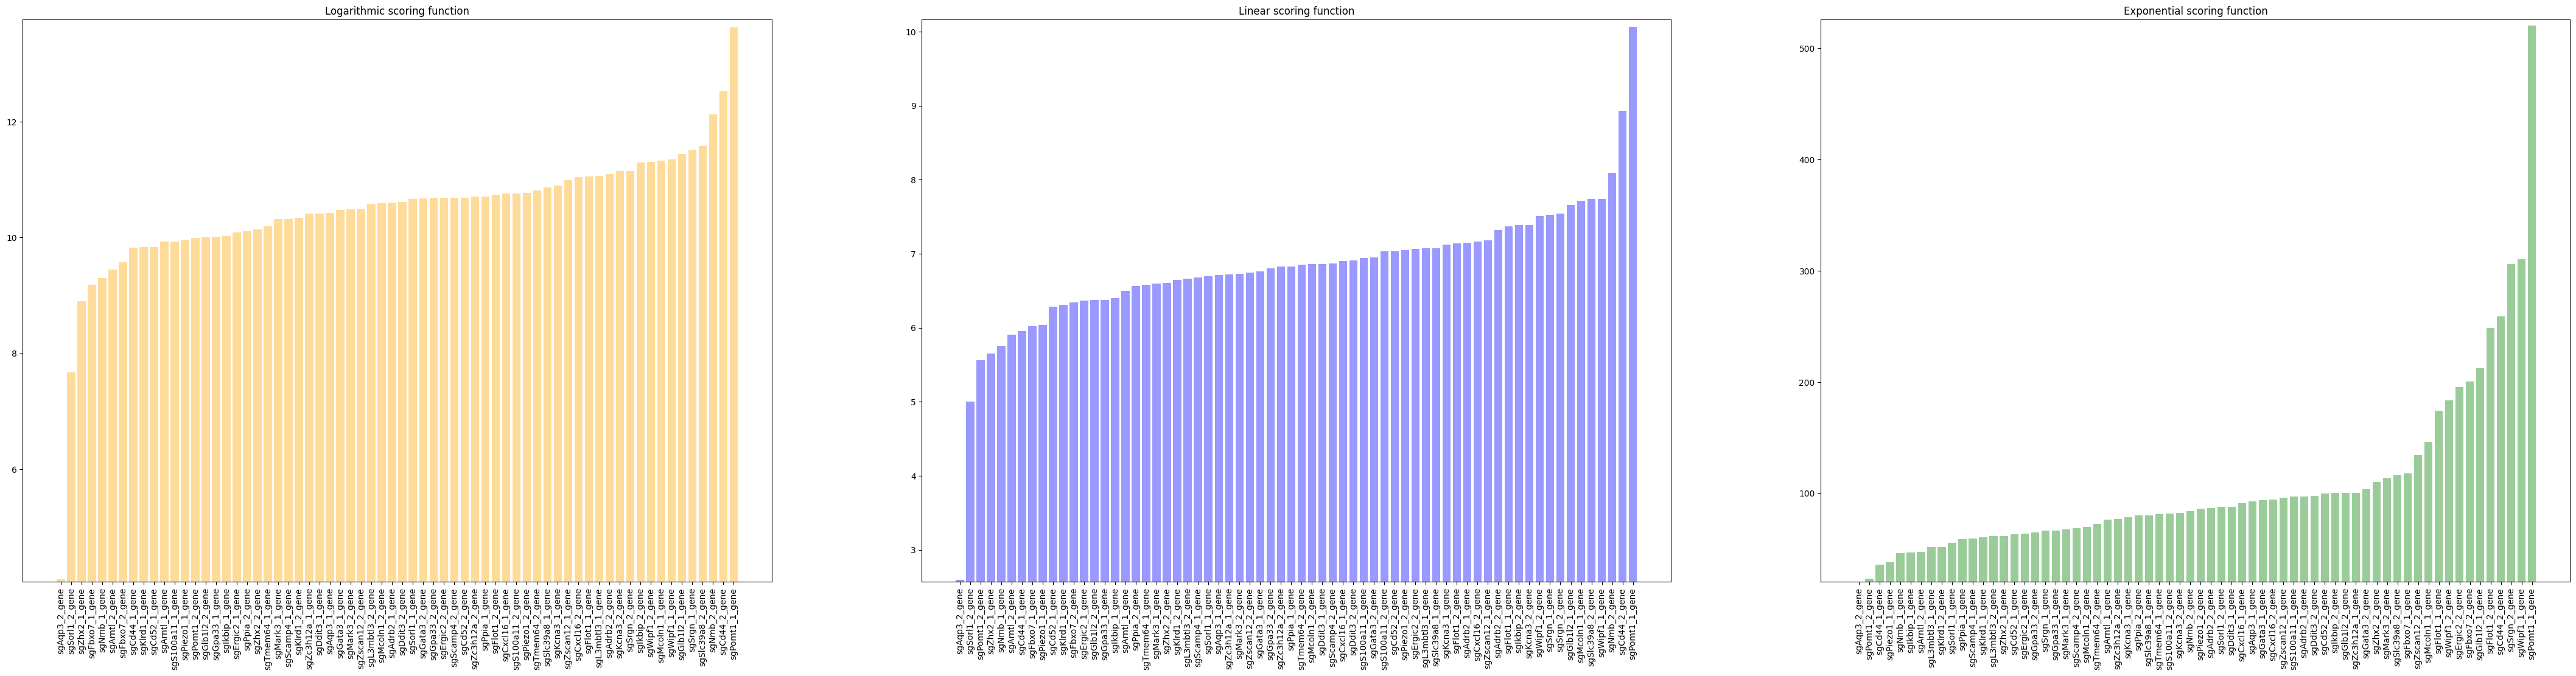

In [45]:
d_df = pd.DataFrame(proportion['B926-1'], index=gdata[:, gdata.var_names != 'sgnon-targeting'].var_names.tolist())
linear_scoring = np.linspace(0, 10, 20)
ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])
exp_scoring = np.array([np.exp(x) for x in np.linspace(0, 10, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(ln_scoring, 1 - x), axis=1).sum(axis=1).sort_values()
linear_sc = d_df.apply(lambda x: np.multiply(linear_scoring, 1 - x), axis=1).sum(axis=1).sort_values()
exp_sc = d_df.apply(lambda x: np.multiply(exp_scoring, 1 - x), axis=1).sum(axis=1).sort_values()

fig, ax = plt.subplots(1, 3, figsize=(54, 12))
ax[0].bar(ln_sc.index, ln_sc, color='orange', alpha=0.4)
ax[1].bar(linear_sc.index, linear_sc, color='blue', alpha=0.4)
ax[2].bar(exp_sc.index, exp_sc, color='green', alpha=0.4)

ax[0].set_ylim(min(ln_sc) * 0.99, max(ln_sc) * 1.01)
ax[1].set_ylim(min(linear_sc) * 0.99, max(linear_sc) * 1.01)
ax[2].set_ylim(min(exp_sc) * 0.99, max(exp_sc) * 1.01)

ax[0].set_xticklabels(ln_sc.index, rotation=90)
ax[1].set_xticklabels(linear_sc.index, rotation=90)
ax[2].set_xticklabels(exp_sc.index, rotation=90)

ax[0].set_title('Logarithmic scoring function')
ax[1].set_title('Linear scoring function')
ax[2].set_title('Exponential scoring function')
plt.show()

/tmp/ipykernel_17104/1482540153.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)


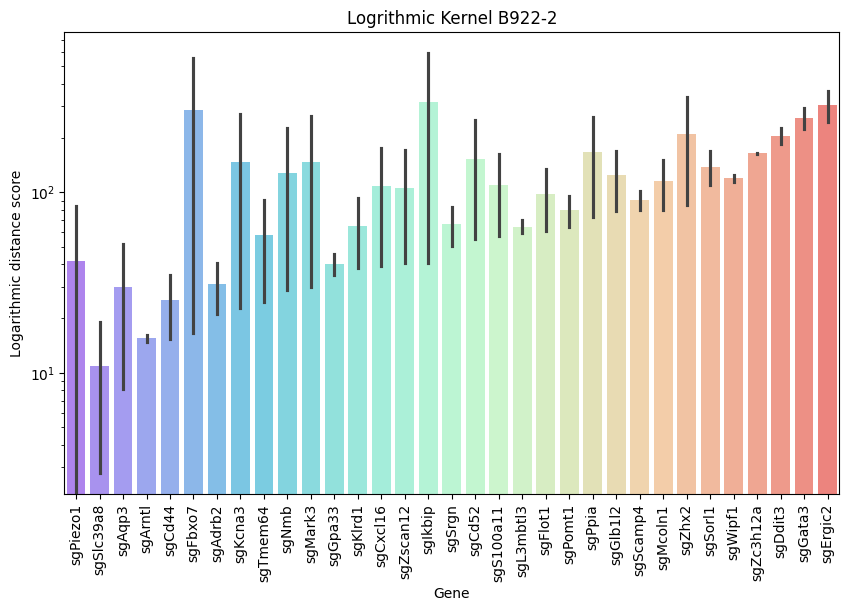

In [54]:
d_df = pd.DataFrame(proportion['B922-2'], index=gdata[:, gdata.var_names != 'sgnon-targeting'].var_names.tolist())
#d_df = pd.concat([d_df, pd.DataFrame(proportion_rand, index=['Random_20', '_', '_', '_', 'Random_10000']).iloc[[0, 4], :]], axis=0)

ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(exp_scoring, 1-x), axis=1).sum(axis=1).sort_values()
ln_df = pd.DataFrame(ln_sc, columns=['ln_dist'])
ln_df['gene'] = ln_df.index.str.split('_').str.get(0).tolist()
ln_df.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)
plt.xticks(rotation=90)
# plt.ylim(0,)
plt.gca().set_yscale('log')
plt.xlabel('Gene')
plt.ylabel('Logarithmic distance score')
plt.title('Logrithmic Kernel ' + 'B922-2')
plt.show()

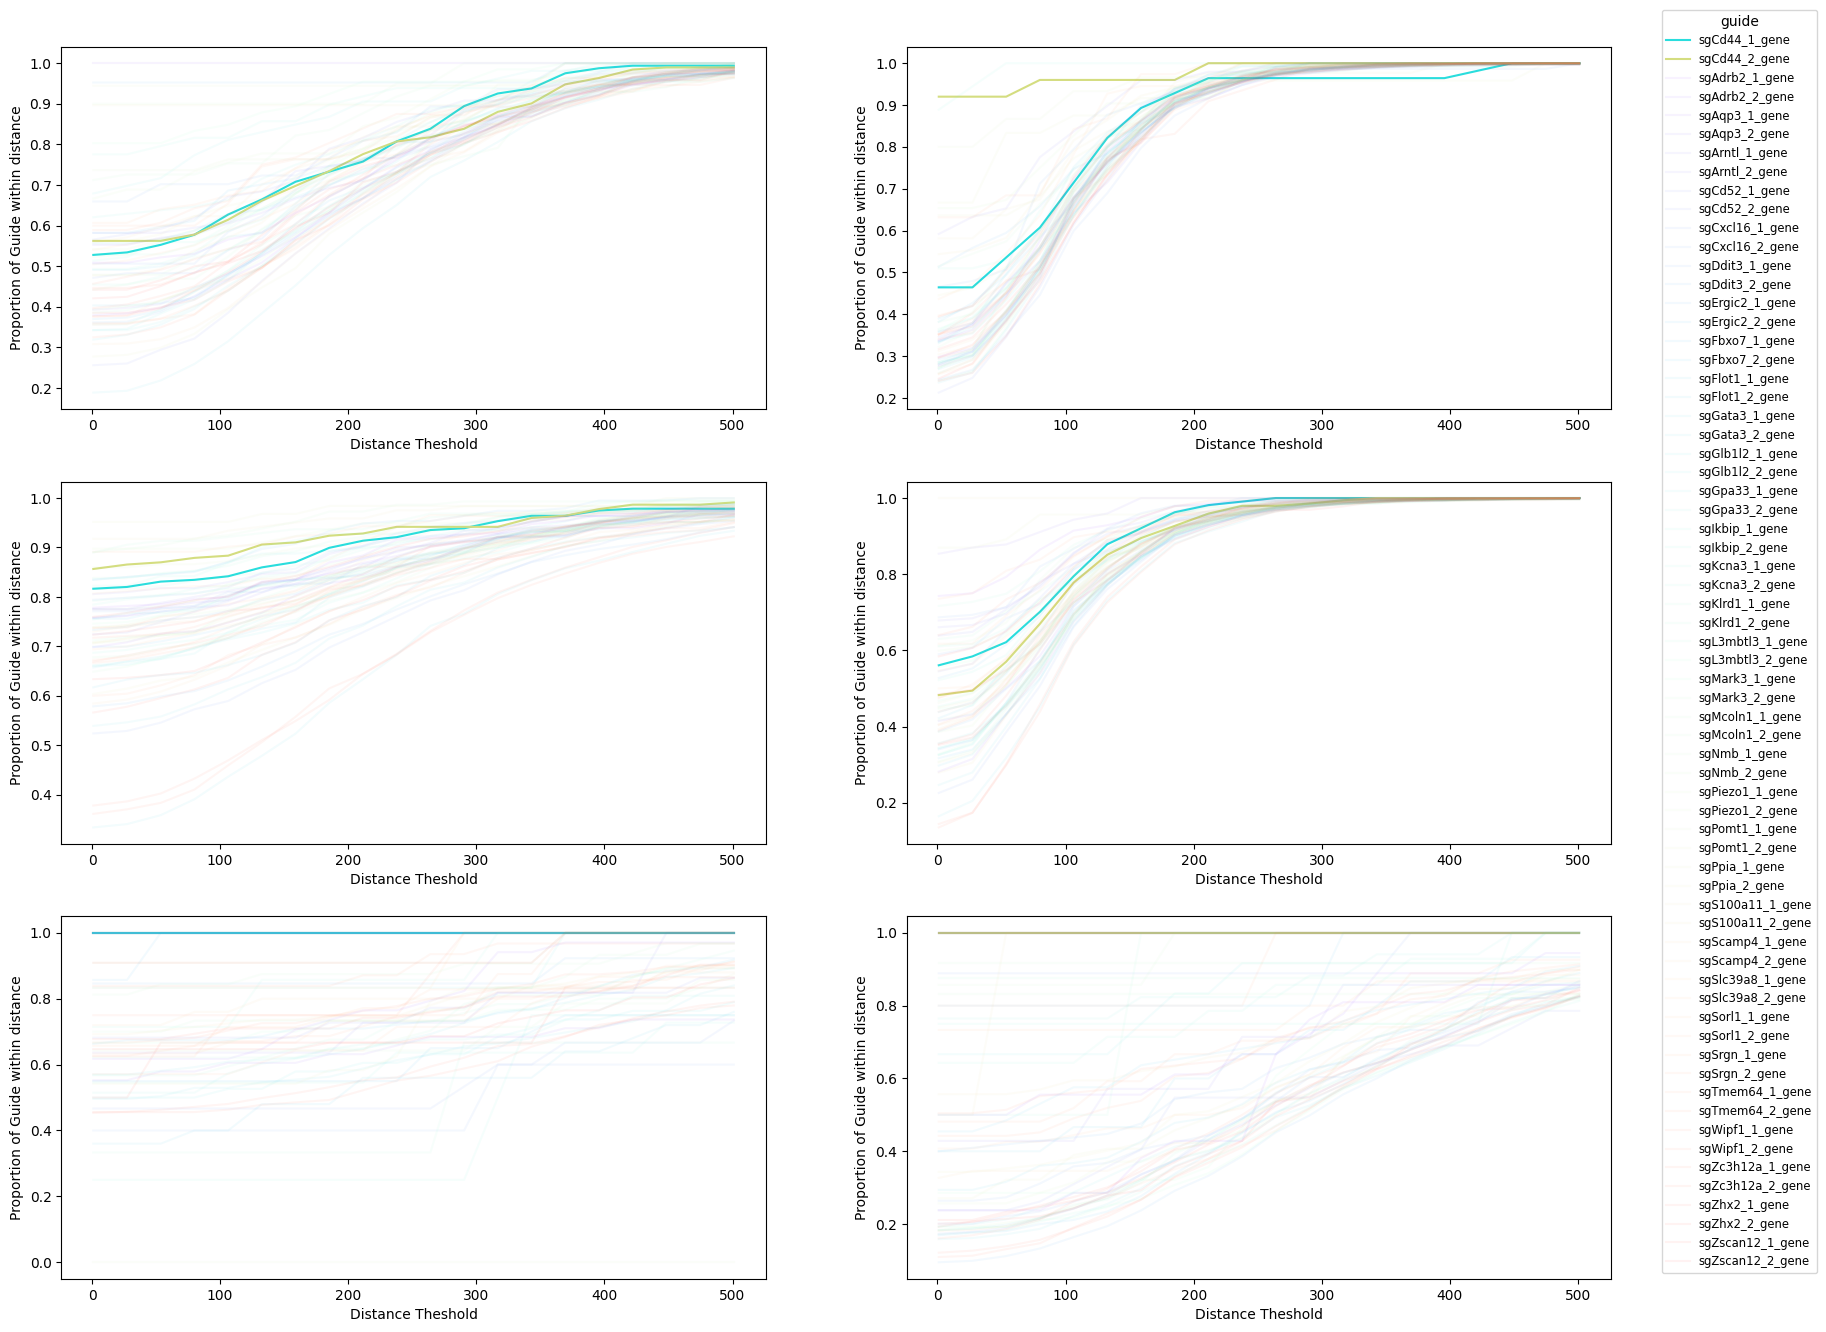

In [159]:
fig, ax = plt.subplots(3, 2, figsize=(20, 16))
for idx, marker in enumerate(gdata.obs.marker.unique()):
    d_df = pd.DataFrame(proportion_bin[marker]).melt()
    d_df.index = gdata[:, gdata.var_names != 'sgNTC'].var_names.tolist() * 20
    d_df.reset_index(inplace=True)
    
    if idx == 5: legend = True
    else: legend = False
    sns.lineplot(d_df[d_df['index'].str.startswith('sgCd44')], x='variable', y='value', hue='index', palette='rainbow', ax=ax[idx // 2, idx % 2], legend = legend, alpha=1)
    sns.lineplot(d_df[~d_df['index'].str.startswith('sgCd44')], x='variable', y='value', hue='index', palette='rainbow', ax=ax[idx // 2, idx % 2], legend = legend, alpha=0.05)
    ax[idx // 2, idx % 2].set_xlabel('Distance Theshold')
    ax[idx // 2, idx % 2].set_ylabel('Proportion of Guide within distance')
    if idx == 5: ax[idx // 2, idx % 2].legend(title='guide', loc='lower right', fontsize='small', bbox_to_anchor=(1.3, 0))

# Exclusive

In [44]:
import scanpy as sc
gdata = sc.read_h5ad('../20240702-Exclusive/RNA/spatial.filtered.guide.bin100.h5')

In [45]:
from bin import utils

In [6]:
# gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [46]:
import anndata as ad
sgs = gdata.var_names.str.split('ing_', n=1).str[0]
sgs_grouped = pd.DataFrame(gdata.X.toarray(), columns=gdata.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()

cgdata = ad.AnnData(sgs_grouped, obs=gdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
cgdata.obsm['spatial'] = gdata.obsm['spatial']
gdata = cgdata.copy()

/tmp/ipykernel_28658/189470726.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [47]:
from scipy.spatial import distance_matrix
from tqdm import tqdm
import numpy as np
import pandas as pd
proportion = {}
for marker in gdata.obs.marker.unique():
    gdata_ = gdata[gdata.obs['marker'] == marker].copy()
    if marker == 'A':
        gdata_ = gdata_[gdata_.obsm['spatial'][:, 1] > 4000].copy()
    else:
        gdata_ = gdata_[gdata_.obsm['spatial'][:, 1] < 6500].copy()
    proportion[marker] = {}
    for threshold in tqdm(np.linspace(1, 501, 20)):
        proportion[marker][threshold] = []
        for guide in gdata.var_names:
            if guide == 'sgnon-target': continue
            guide_data = gdata_[gdata_[:, guide].X > 0].copy()
            ntc_data = gdata_[gdata_[:, 'sgnon-target'].X > 0].copy()
            in_distance = guide_data[(distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0, guide].X.sum()
            proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_28658/1499091920.py:20: RuntimeWarning: invalid value encountered in divide
  proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())
/tmp/ipykernel_28658/1499091920.py:20: RuntimeWarning: invalid value encountered in divide
  proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())
/tmp/ipykernel_28658/1499091920.py:20: RuntimeWarning: invalid value encountered in divide
  proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())
  5%|▌         | 1/20 [00:00<00:05,  3.21it/s]/tmp/ipykernel_28658/1499091920.py:20: RuntimeWarning: invalid value encountered in divide
  proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())
/tmp/ipykernel_28658/1499091920.py:20: RuntimeWarning: invalid value encountered in divide
  proportion[marker][threshold].append(in_distance / guide_data[:, guide].X.sum())
/tmp/ipykernel_28658/1499091920.py:20: Runtime

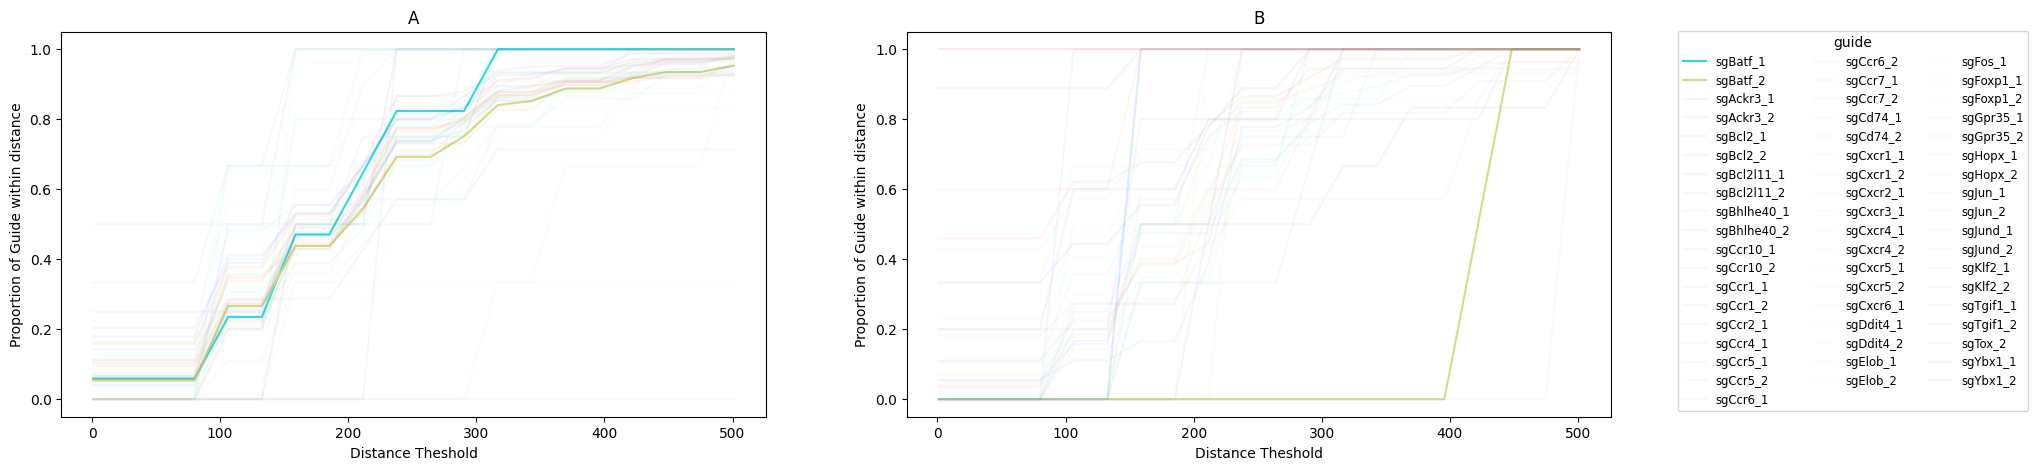

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for idx, marker in enumerate(gdata.obs.marker.unique()):
    d_df = pd.DataFrame(proportion[marker]).melt()
    d_df.index = gdata[:, gdata.var_names != 'sgnon-target'].var_names.tolist() * 20
    d_df.reset_index(inplace=True)

    if idx == 1: legend = True
    else: legend = False
    sns.lineplot(d_df[d_df['index'].str.startswith('sgBatf')], x='variable', y='value', hue='index', palette='rainbow', ax=ax[idx % 2], legend = legend, alpha=1)
    sns.lineplot(d_df[~d_df['index'].str.startswith('sgBatf')], x='variable', y='value', hue='index', palette='rainbow', ax=ax[idx % 2], legend = legend, alpha=0.05)
    ax[idx % 2].set_xlabel('Distance Theshold')
    ax[idx % 2].set_ylabel('Proportion of Guide within distance')
    if idx == 1: ax[idx % 2].legend(title='guide', loc='lower right', fontsize='small', bbox_to_anchor=(1.6, 0), ncols=3)
    ax[idx % 2].set_title(marker)

/tmp/ipykernel_28658/2715758190.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)


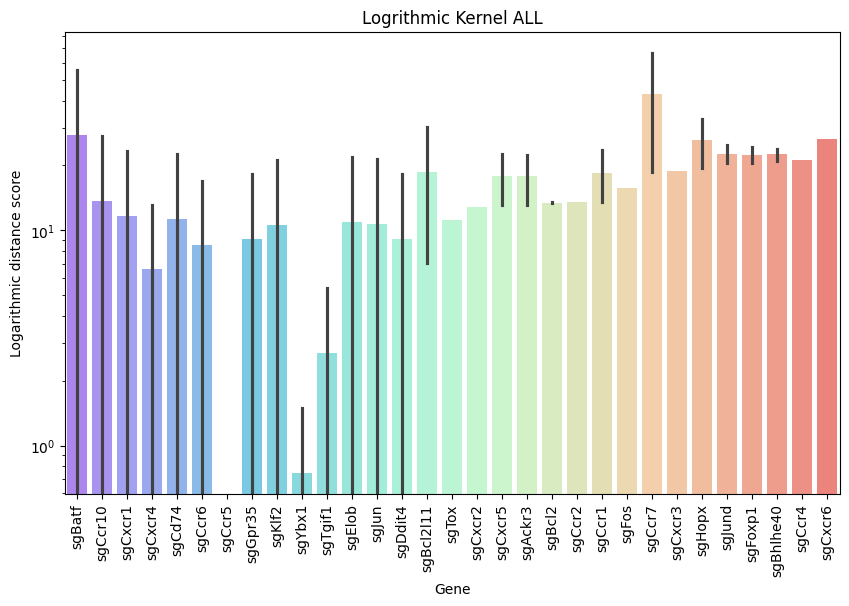

In [53]:
d_df = pd.DataFrame(proportion['B'], index=gdata[:, gdata.var_names != 'sgnon-target'].var_names.tolist())
#d_df = pd.concat([d_df, pd.DataFrame(proportion_rand, index=['Random_20', '_', '_', '_', 'Random_10000']).iloc[[0, 4], :]], axis=0)

linear_scoring = np.linspace(0, 10, 20)
ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])
exp_scoring = np.array([np.exp(x) for x in np.linspace(0, 10, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(ln_scoring, 1-x), axis=1).sum(axis=1).sort_values()
ln_df = pd.DataFrame(ln_sc, columns=['ln_dist'])
ln_df['gene'] = ln_df.index.str.split('_').str.get(0).tolist()
ln_df.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)
plt.xticks(rotation=90)
# plt.ylim(0,)
plt.gca().set_yscale('log')
plt.xlabel('Gene')
plt.ylabel('Logarithmic distance score')
plt.title('Logrithmic Kernel ' + 'ALL')
plt.show()

/tmp/ipykernel_28658/1954950159.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)


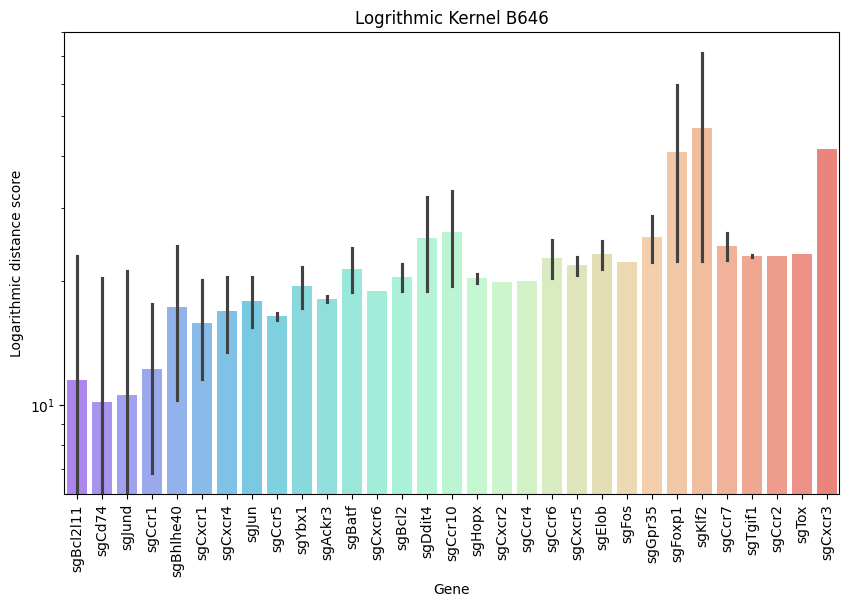

In [51]:
d_df = pd.DataFrame(proportion['A'], index=gdata[:, gdata.var_names != 'sgnon-target'].var_names.tolist())
#d_df = pd.concat([d_df, pd.DataFrame(proportion_rand, index=['Random_20', '_', '_', '_', 'Random_10000']).iloc[[0, 4], :]], axis=0)

linear_scoring = np.linspace(0, 10, 20)
ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])
exp_scoring = np.array([np.exp(x) for x in np.linspace(0, 10, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(ln_scoring, 1-x), axis=1).sum(axis=1).sort_values()
ln_df = pd.DataFrame(ln_sc, columns=['ln_dist'])
ln_df['gene'] = ln_df.index.str.split('_').str.get(0).tolist()
ln_df.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)
plt.xticks(rotation=90)
# plt.ylim(0,)
plt.gca().set_yscale('log')
plt.xlabel('Gene')
plt.ylabel('Logarithmic distance score')
plt.title('Logrithmic Kernel ' + 'B646')
plt.show()

/tmp/ipykernel_28658/3556324049.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)


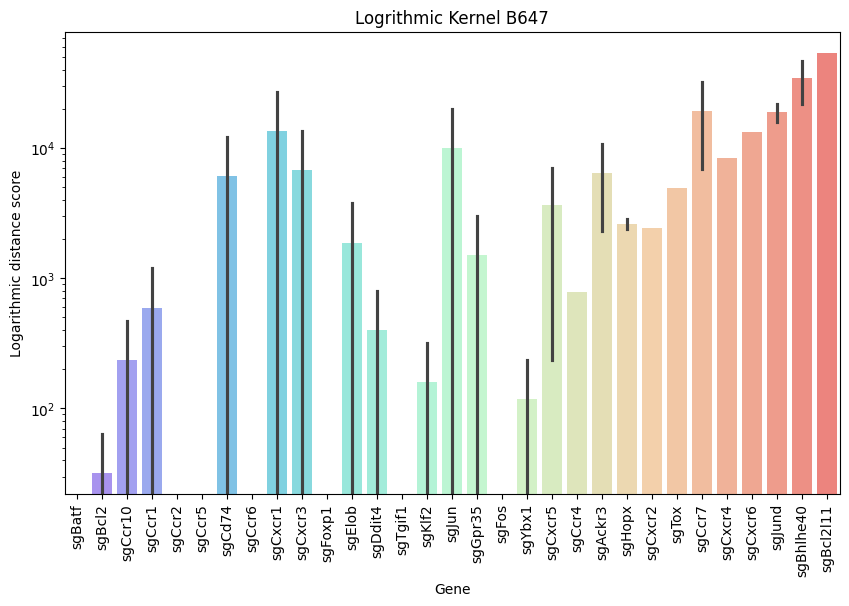

In [43]:
d_df = pd.DataFrame(proportion['B'], index=gdata[:, gdata.var_names != 'sgnon-target'].var_names.tolist())
#d_df = pd.concat([d_df, pd.DataFrame(proportion_rand, index=['Random_20', '_', '_', '_', 'Random_10000']).iloc[[0, 4], :]], axis=0)

linear_scoring = np.linspace(0, 10, 20)
ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])
exp_scoring = np.array([np.exp(x) for x in np.linspace(0, 10, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(exp_scoring, 1-x), axis=1).sum(axis=1).sort_values()
ln_df = pd.DataFrame(ln_sc, columns=['ln_dist'])
ln_df['gene'] = ln_df.index.str.split('_').str.get(0).tolist()
ln_df.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)
plt.xticks(rotation=90)
# plt.ylim(0,)
plt.gca().set_yscale('log')
plt.xlabel('Gene')
plt.ylabel('Logarithmic distance score')
plt.title('Logrithmic Kernel ' + 'B647')
plt.show()